# **Early Warning Signals in League of Legends**

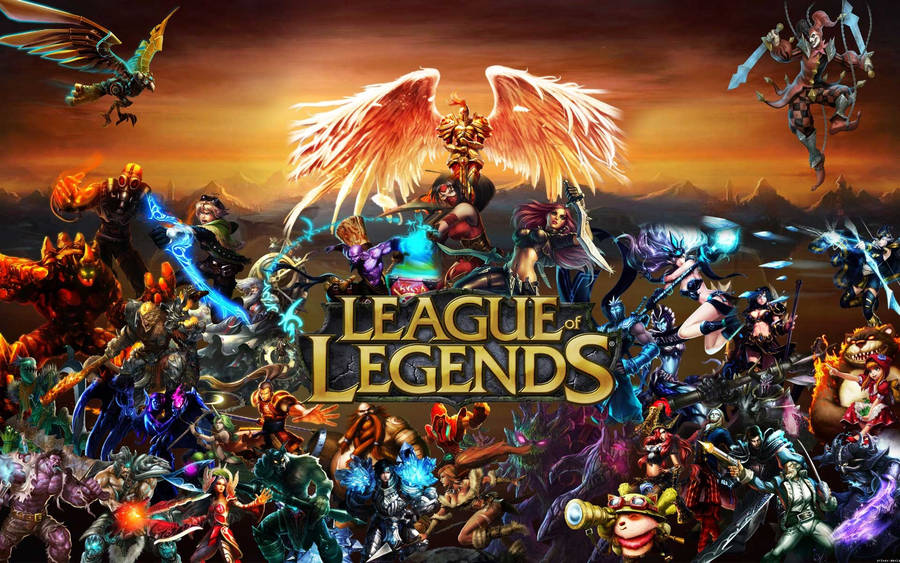

Anyone who has spent enough time in ranked League of Legends knows this feeling all too well. The early game goes smoothly, your team builds a solid gold lead, everything feels under control, and then the enemy suddenly sneaks a Baron or sets up a coordinated fight you never saw coming. In a split second, the momentum shifts and the game you thought you were winning slips away. In moments like that, every player wishes they had better knowledge when this happens.

This project is built around that idea. Using data science tools, I created a full pipeline that gathers official Riot match and timeline data from the 2024–2025 ranked season, reconstructs the evolving team state every ten seconds and labels when major events such as Baron, Dragon or teamfights are about to occur. With this structured dataset, I trained temporal and context-aware models designed to issue early warnings before these high-impact moments happen. The aim is to provide a learning tool for the players to study their matches more efficiently and gain knowledge about the triggers that lead to an event.


### **Few preps to do**

First is to get the API key from the dev portal. Link: https://developer.riotgames.com/

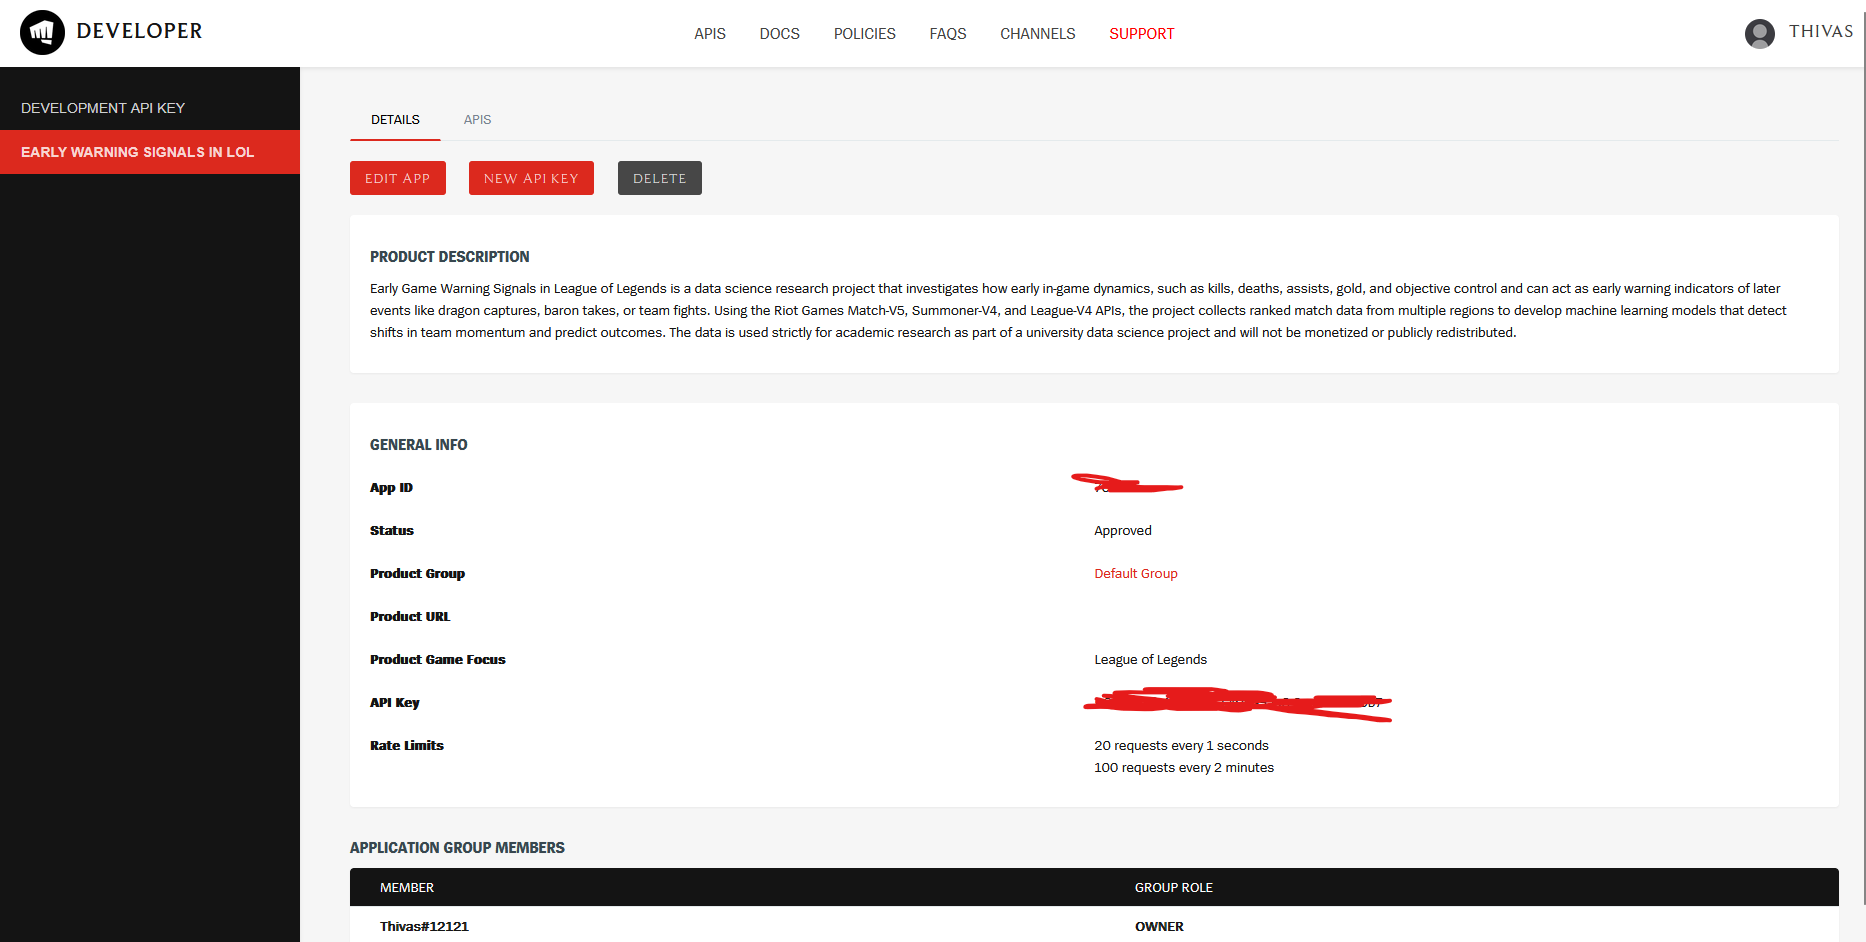

And using riotwatcher library to make it easier to use the API. It makes sure to not get consistent errors while making requests. Documentation Link: https://riot-watcher.readthedocs.io/

## **Loading and inspecting the data**

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("/content/drive/MyDrive/final_dataset.csv")
df.sample(5)

,match_id,t,gold_blue,gold_red,xp_blue,xp_red,gold_diff,xp_diff,cs_lane_t1,cs_lane_t2,...,totdmgdealt_blue,totdmgdealt_red,totdmgtochamp_blue,totdmgtochamp_red,totheal_blue,totheal_red,wardsplaced_blue,wardsplaced_red,wardskilled_blue,wardskilled_red
64881,EUW1_7492696512,350,7470.0,7580.0,7772.0,8340.0,-110.0,-568.0,103.0,102.0,...,59419.0,50469.4,8468.2,4774.2,4009.8,3464.0,5.6,6.0,1.6,1.6
336564,EUW1_7592797649,580,16056.0,16089.0,17367.0,16892.0,-33.0,475.0,205.0,228.0,...,167151.4,148601.4,27391.2,13450.2,10173.2,11122.8,14.6,9.6,1.8,5.4
148479,EUW1_7544744266,1690,58024.0,53973.0,67295.0,63271.0,4051.0,4024.0,767.0,655.0,...,301831.4,340707.8,39362.4,31416.0,15764.2,13592.8,21.4,27.6,15.2,7.0
126884,EUW1_7525092855,450,12111.0,11718.0,12437.0,11716.0,393.0,721.0,143.0,145.0,...,128376.4,131184.8,16371.4,21071.6,7821.6,8937.0,13.2,17.2,4.6,5.4
54092,EUW1_7484730220,1360,46022.0,43040.0,52511.0,51316.0,2982.0,1195.0,601.0,573.0,...,208610.0,227556.2,28537.6,28372.4,12096.0,8161.6,21.8,21.2,9.0,8.4


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484255 entries, 0 to 484254
Data columns (total 86 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   match_id                   484255 non-null  object 
 1   t                          484255 non-null  int64  
 2   gold_blue                  484255 non-null  float64
 3   gold_red                   484255 non-null  float64
 4   xp_blue                    484255 non-null  float64
 5   xp_red                     484255 non-null  float64
 6   gold_diff                  484255 non-null  float64
 7   xp_diff                    484255 non-null  float64
 8   cs_lane_t1                 484255 non-null  float64
 9   cs_lane_t2                 484255 non-null  float64
 10  cs_jungle_t1               484255 non-null  float64
 11  cs_jungle_t2               484255 non-null  float64
 12  cs_total_t1                484255 non-null  float64
 13  cs_total_t2                48

This dataset contains **484,255 time-stamped records**, each representing the game state at a specific moment. It provides **86 engineered features** spanning economy, experience, positioning, vision, combat activity, and objective control, making it a high-resolution temporal dataset suitable for predictive modeling and event-forecasting analysis.

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
t,484255.0,847.627655,534.647872,0.0,400.0,810.0,1250.0,3030.0
gold_blue,484255.0,26216.313781,18390.533759,2500.0,10293.0,23443.0,39596.0,103317.0
gold_red,484255.0,26069.091468,18310.374913,2500.0,10239.0,23297.0,39275.0,101445.0
xp_blue,484255.0,29809.925033,22918.354818,0.0,10327.0,26168.0,45767.0,131185.0
xp_red,484255.0,29799.859467,22939.336310,0.0,10298.0,26126.0,45783.0,140196.0
...,...,...,...,...,...,...,...,...
totheal_red,484255.0,9068.492495,3851.730303,0.0,6425.2,8595.8,10942.4,35851.4
wardsplaced_blue,484255.0,14.376378,4.377314,0.0,11.6,14.0,17.0,32.8
wardsplaced_red,484255.0,14.321328,4.346595,0.0,11.4,14.0,16.8,38.0
wardskilled_blue,484255.0,4.617851,2.199987,0.0,3.0,4.4,6.0,15.2


Gold and experience values span a very wide range, with averages around **26,000–29,000** but maximums exceeding 100,000, showing how dramatically resource totals escalate as the game progresses. In contrast, future-event labels remain extremely sparse, with Baron 30s events occurring in only about **1.2 percent** of rows, Dragon 30s in about **6.3 percent**, and Teamfight 30s in **roughly 10 percent**, highlighting a strong **class imbalance** that will shape downstream modeling decisions.

In [ ]:
df.shape

(484255, 86)

In [ ]:
dup_full = df.duplicated().sum()
dup_keys = df.duplicated(subset=["match_id", "t"]).sum()

print("Duplicate full rows:", dup_full)
print("Duplicate (match_id, t) rows:", dup_keys)

Duplicate full rows: 0
Duplicate (match_id, t) rows: 0


In [ ]:
missing_counts = df.isnull().sum()
missing_percent = (df.isnull().mean() * 100).round(4)

print("Missing value counts:\n", missing_counts)
print("\nMissing value %:\n", missing_percent)

Missing value counts:
 match_id            0
t                   0
gold_blue           0
gold_red            0
xp_blue             0
                   ..
totheal_red         0
wardsplaced_blue    0
wardsplaced_red     0
wardskilled_blue    0
wardskilled_red     0
Length: 86, dtype: int64

Missing value %:
 match_id            0.0
t                   0.0
gold_blue           0.0
gold_red            0.0
xp_blue             0.0
                   ... 
totheal_red         0.0
wardsplaced_blue    0.0
wardsplaced_red     0.0
wardskilled_blue    0.0
wardskilled_red     0.0
Length: 86, dtype: float64


## **Data Quality Diagnosis**

In [ ]:
cols = df.columns.tolist()

gold_cols = ["gold_blue", "gold_red", "gold_diff"]
xp_cols = ["xp_blue", "xp_red", "xp_diff"]
cs_cols = ["cs_lane_t1","cs_lane_t2", "cs_jungle_t1","cs_jungle_t2", "cs_total_t1","cs_total_t2", "cs_total_diff"]
level_cols = ["avg_level_t1","avg_level_t2","level_diff"]
status_cols = ["alive_t1","alive_t2","alive_diff", "low_hp_t1","low_hp_t2", "group_t1","group_t2", "cluster_density","distance_between_teams", "spread_t1","spread_t2"]
objective_position_cols = ["champs_near_baron_t1","champs_near_baron_t2", "champs_near_dragon_t1","champs_near_dragon_t2"]
combat_30_cols = ["kills_30_t1","kills_30_t2", "deaths_30_t1","deaths_30_t2"]
combat_60_cols = ["kills_60_t1","kills_60_t2", "deaths_60_t1","deaths_60_t2", "wards_placed_60_t1","wards_placed_60_t2", "wards_killed_60_t1","wards_killed_60_t2", "items_purchased_60_t1","items_purchased_60_t2",]
objective_taken_cols = ["dragons_t1","dragons_t2", "barons_t1","barons_t2", "heralds_t1","heralds_t2", "towers_t1","towers_t2", "inhibs_t1","inhibs_t2"]
timer_cols = ["time_since_last_baron", "time_since_last_dragon", "time_since_last_teamfight", "teamfight_recent_20"]
label_cols = ["baron", "dragon", "teamfight"]
combat_raw_cols = ["kills_blue","kills_red", "deaths_blue","deaths_red", "assists_blue","assists_red"]
damage_cols = ["totdmgdealt_blue","totdmgdealt_red", "totdmgtochamp_blue","totdmgtochamp_red", "totheal_blue","totheal_red"]
vision_cols = ["wardsplaced_blue","wardsplaced_red", "wardskilled_blue","wardskilled_red"]

print("\nECONOMY:", gold_cols + xp_cols)
print("\nCS:", cs_cols)
print("\nLEVELS:", level_cols)
print("\nTEAM STATE:", status_cols)
print("\nPOSITION PRESSURE:", objective_position_cols)
print("\nCOMBAT (30s):", combat_30_cols)
print("\nCOMBAT (60s):", combat_60_cols)
print("\nOBJECTIVES TAKEN:", objective_taken_cols)
print("\nTIMERS:", timer_cols)
print("\nLABELS:", label_cols)
print("\nCOMBAT RAW:", combat_raw_cols)
print("\nDAMAGE:", damage_cols)
print("\nVISION:", vision_cols)


ECONOMY: ['gold_blue', 'gold_red', 'gold_diff', 'xp_blue', 'xp_red', 'xp_diff']

CS: ['cs_lane_t1', 'cs_lane_t2', 'cs_jungle_t1', 'cs_jungle_t2', 'cs_total_t1', 'cs_total_t2', 'cs_total_diff']

LEVELS: ['avg_level_t1', 'avg_level_t2', 'level_diff']

TEAM STATE: ['alive_t1', 'alive_t2', 'alive_diff', 'low_hp_t1', 'low_hp_t2', 'group_t1', 'group_t2', 'cluster_density', 'distance_between_teams', 'spread_t1', 'spread_t2']

POSITION PRESSURE: ['champs_near_baron_t1', 'champs_near_baron_t2', 'champs_near_dragon_t1', 'champs_near_dragon_t2']

COMBAT (30s): ['kills_30_t1', 'kills_30_t2', 'deaths_30_t1', 'deaths_30_t2']

COMBAT (60s): ['kills_60_t1', 'kills_60_t2', 'deaths_60_t1', 'deaths_60_t2', 'wards_placed_60_t1', 'wards_placed_60_t2', 'wards_killed_60_t1', 'wards_killed_60_t2', 'items_purchased_60_t1', 'items_purchased_60_t2']

OBJECTIVES TAKEN: ['dragons_t1', 'dragons_t2', 'barons_t1', 'barons_t2', 'heralds_t1', 'heralds_t2', 'towers_t1', 'towers_t2', 'inhibs_t1', 'inhibs_t2']

TIMERS: [

In [ ]:
cols_nonneg = (
    gold_cols + xp_cols + cs_cols + level_cols + status_cols +
    objective_position_cols + combat_30_cols + combat_60_cols +
    objective_taken_cols + timer_cols + combat_raw_cols +
    damage_cols + vision_cols
)

for col in cols_nonneg:
    if col in df.columns:
        neg_count = (df[col] < 0).sum()
        if neg_count > 0:
            print(f"{col}: {neg_count} negative values found")
    else:
        print(f"{col}: column missing in dataset")

gold_diff: 219045 negative values found
xp_diff: 222258 negative values found
cs_total_diff: 224779 negative values found
level_diff: 171971 negative values found


In [ ]:
for col in vision_cols:
    if col in df.columns:
        fractional = (df[col] % 1 != 0).sum()
        if fractional > 0:
            print(f"{col}: {fractional} rows have fractional values")
    else:
        print(f"{col}: column missing")

wardsplaced_blue: 385236 rows have fractional values
wardsplaced_red: 383129 rows have fractional values
wardskilled_blue: 388076 rows have fractional values
wardskilled_red: 385404 rows have fractional values


## **Cleaning the data**

In [ ]:
# remove duplicates
df = df.drop_duplicates()
df = df.drop_duplicates(subset=["match_id", "t"])

# sort properly
df = df.sort_values(["match_id", "t"]).reset_index(drop=True)

In [ ]:
nonneg_cols = (
    gold_cols + xp_cols +
    cs_cols + level_cols +
    status_cols + objective_position_cols +
    combat_30_cols + combat_60_cols +
    objective_taken_cols + timer_cols +
    combat_raw_cols + damage_cols + vision_cols
)

# clip negatives to zero
for c in nonneg_cols:
    if c in df.columns:
        df[c] = df[c].clip(lower=0)

In [ ]:
for c in vision_cols:
    if c in df.columns:
        df[c] = df[c].round().astype(int)

In [ ]:
# recompute gold and xp differences
if "gold_blue" in df.columns and "gold_red" in df.columns:
    df["gold_diff"] = df["gold_blue"] - df["gold_red"]

if "xp_blue" in df.columns and "xp_red" in df.columns:
    df["xp_diff"] = df["xp_blue"] - df["xp_red"]


In [ ]:
weird_matches = 0

for mid, grp in df.groupby("match_id"):
    diffs = grp["t"].diff().dropna()
    if not (diffs == diffs.iloc[0]).all():
        weird_matches += 1

print("Matches with inconsistent t-spacing:", weird_matches)


Matches with inconsistent t-spacing: 0


In [ ]:
kill_cols = [
    "kills_blue", "kills_red",
    "kills_30_t1", "kills_30_t2",
    "kills_60_t1", "kills_60_t2"
]

kill_issues = 0
for c in kill_cols:
    if c not in df.columns:
        continue
    for mid, grp in df.groupby("match_id"):
        if (grp[c].diff().fillna(0) < 0).any():
            kill_issues += 1

print("Matches where kill count decreases:", kill_issues)


Matches where kill count decreases: 11933


## **Final Inspection after cleaning**

In [ ]:
print("Final dataset shape:", df.shape)
print("\nRemaining missing values:", df.isnull().sum().sum())

Final dataset shape: (484255, 86)

Remaining missing values: 0


# **Exploratory Data Analysis**

### **Pre phase**

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd

### **Major events over time throughout the match**

In [ ]:
df["baron"] = df[["y_baron_10", "y_baron_20", "y_baron_30"]].mean(axis=1)
df["dragon"] = df[["y_dragon_10", "y_dragon_20", "y_dragon_30"]].mean(axis=1)
df["teamfight"] = df[["y_teamfight_10", "y_teamfight_20", "y_teamfight_30"]].mean(axis=1)

df["t_min"] = df["t"] // 60
df_time = df.groupby("t_min")[["baron","dragon","teamfight"]].mean().reset_index()

fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=["Baron Probability", "Dragon Probability", "Teamfight Probability"])
events = ["baron","dragon","teamfight"]
colors = ["blue","green","red"]

for i,(ev,c) in enumerate(zip(events,colors), start=1):
    fig.add_trace(go.Scatter(x=df_time["t_min"], y=df_time[ev], mode="lines", line=dict(color=c),
                             name=ev.capitalize()), row=i, col=1)

fig.update_layout(height=900, title="Major events over time throughout the match", template="plotly_white")
fig.update_xaxes(title="Time (min)", row=3)
fig.update_yaxes(title="Probability")
fig.show()

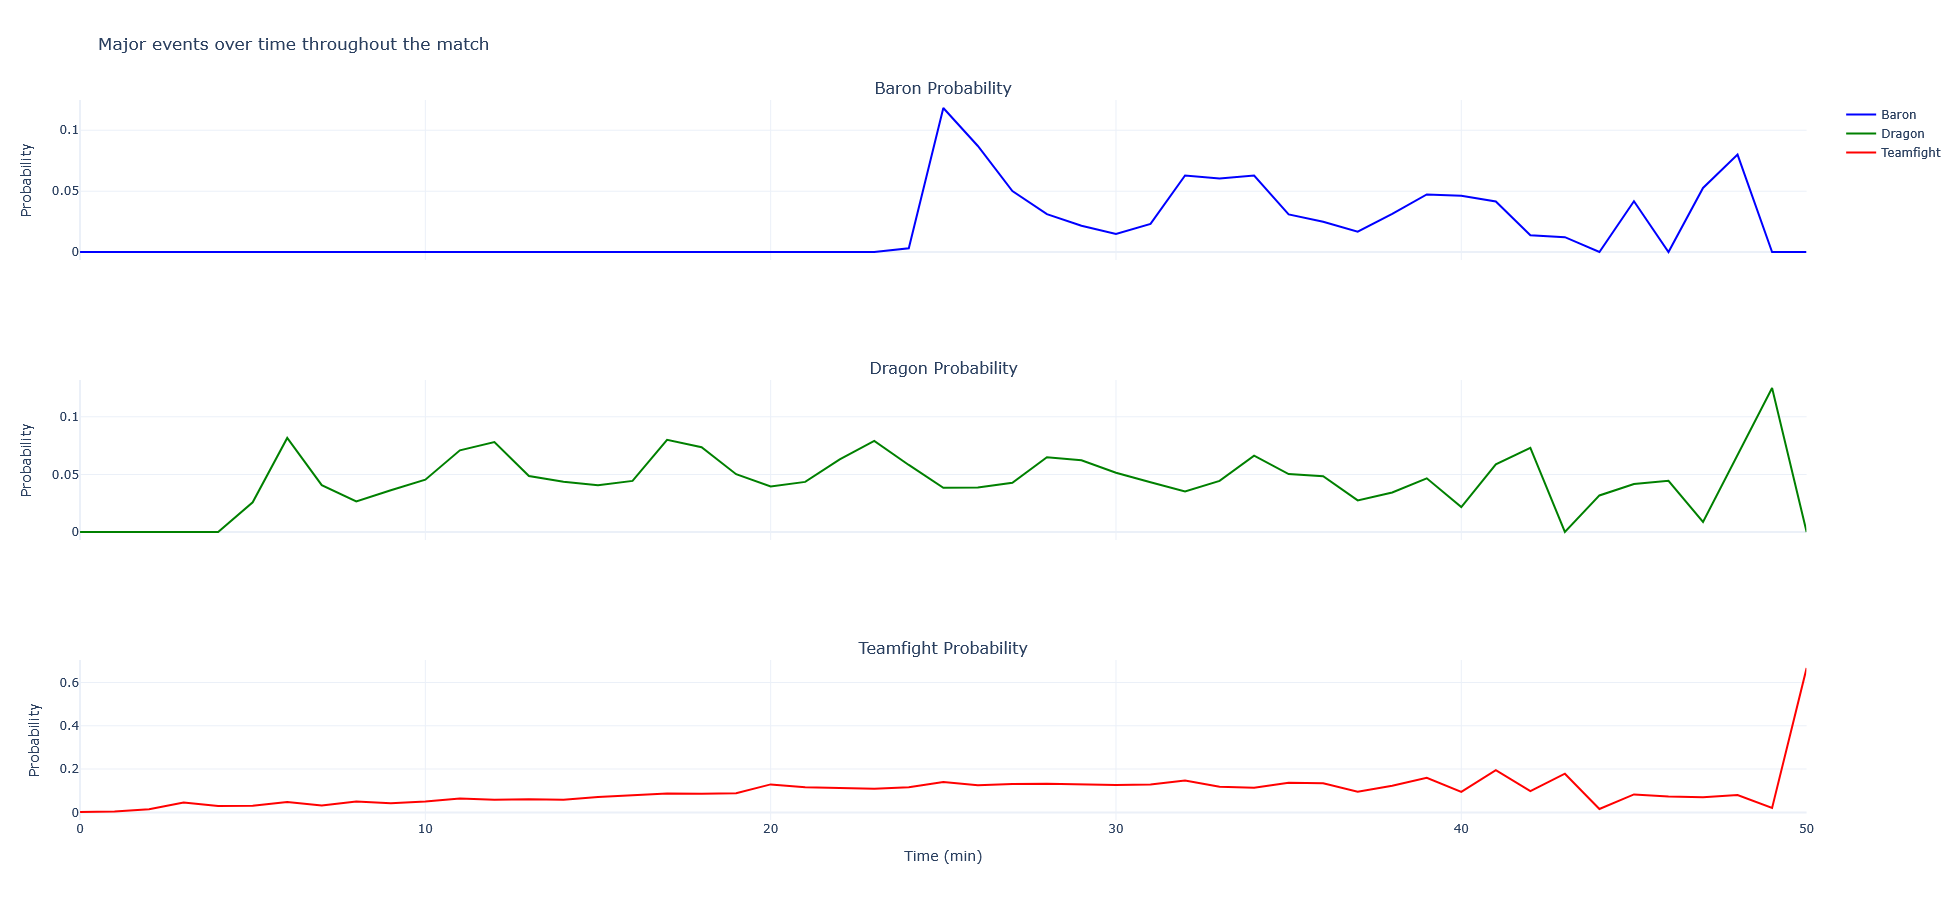

* Event probabilities shift as the match progresses, with dragons becoming relevant early, barons emerging only in the mid-game, and teamfights steadily increasing over time.
* The late game shows the highest volatility, where all three event types become more frequent and spike sharply as matches approach their end.

### **Gold and XP Advantage Trajectory Over Match Duration**

In [ ]:
roll = df.groupby("t_min")[["gold_diff","xp_diff"]].mean().rolling(5).mean().reset_index()
fig = go.Figure()
fig.add_trace(go.Scatter(x=roll["t_min"], y=roll["gold_diff"], name="Gold Diff", mode="lines", line=dict(color="gold")))
fig.add_trace(go.Scatter(x=roll["t_min"], y=roll["xp_diff"], name="XP Diff", mode="lines", line=dict(color="blue")))
fig.update_layout(title="Gold and XP Advantage Trajectory Over Match Duration", xaxis_title="Time (min)",
                  yaxis_title="Difference", template="plotly_white", height=400)
fig.show()

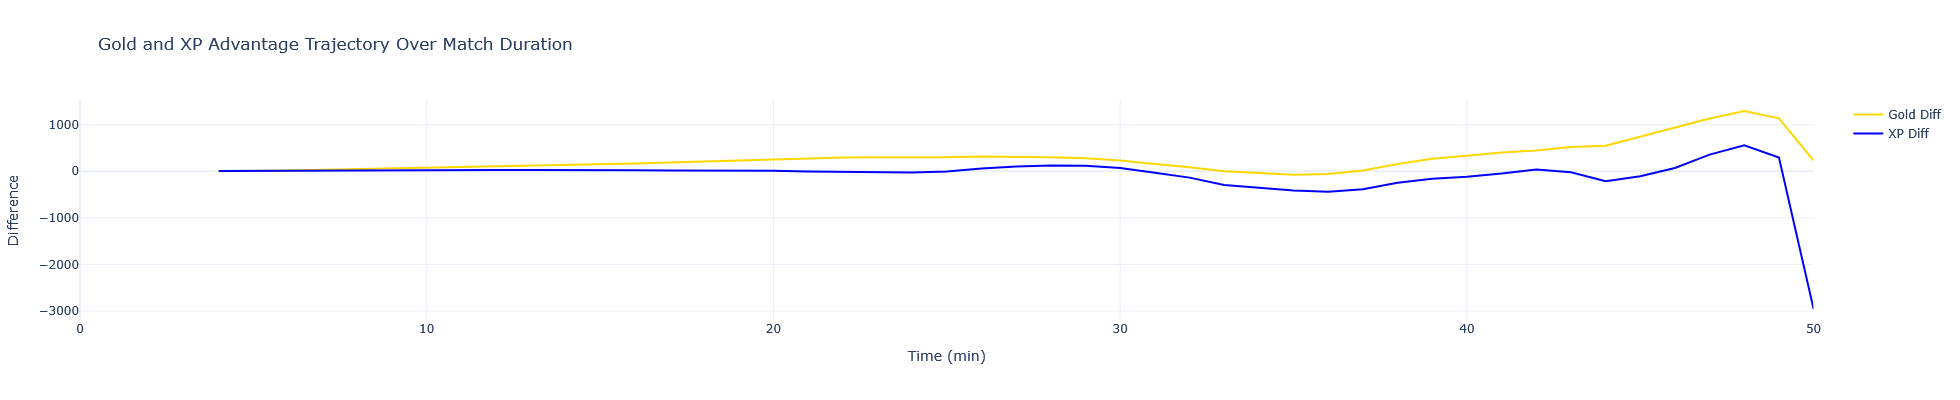

* The gold advantage shows a steady upward trajectory across the match, indicating gradual economic scaling before a sharp late-game spike.
* In contrast, XP advantage remains relatively stable with mild fluctuations until it collapses abruptly near the match’s end, suggesting a disruptive final sequence that heavily altered experience distribution.

### **How Vision Control Shifts Over Time (Blue team vs Red team)**

In [ ]:
df["vision_diff"] = df["wardsplaced_blue"] - df["wardsplaced_red"]
vision_time = df.groupby("t_min")["vision_diff"].mean().reset_index()
fig = px.line(vision_time, x="t_min", y="vision_diff", title="How Vision Control Shifts Over Time",
              labels={"t_min": "Time (min)", "vision_diff": "Vision Difference (Blue - Red)"}, template="plotly_white")
fig.add_annotation(x=0.02, y=1.05, xref="paper", yref="paper", text="Positive = Blue has more vision", showarrow=False, font=dict(color="blue", size=12))
fig.add_annotation(x=0.02, y=1.00, xref="paper", yref="paper", text="Negative = Red has more vision", showarrow=False, font=dict(color="red", size=12))
fig.show()

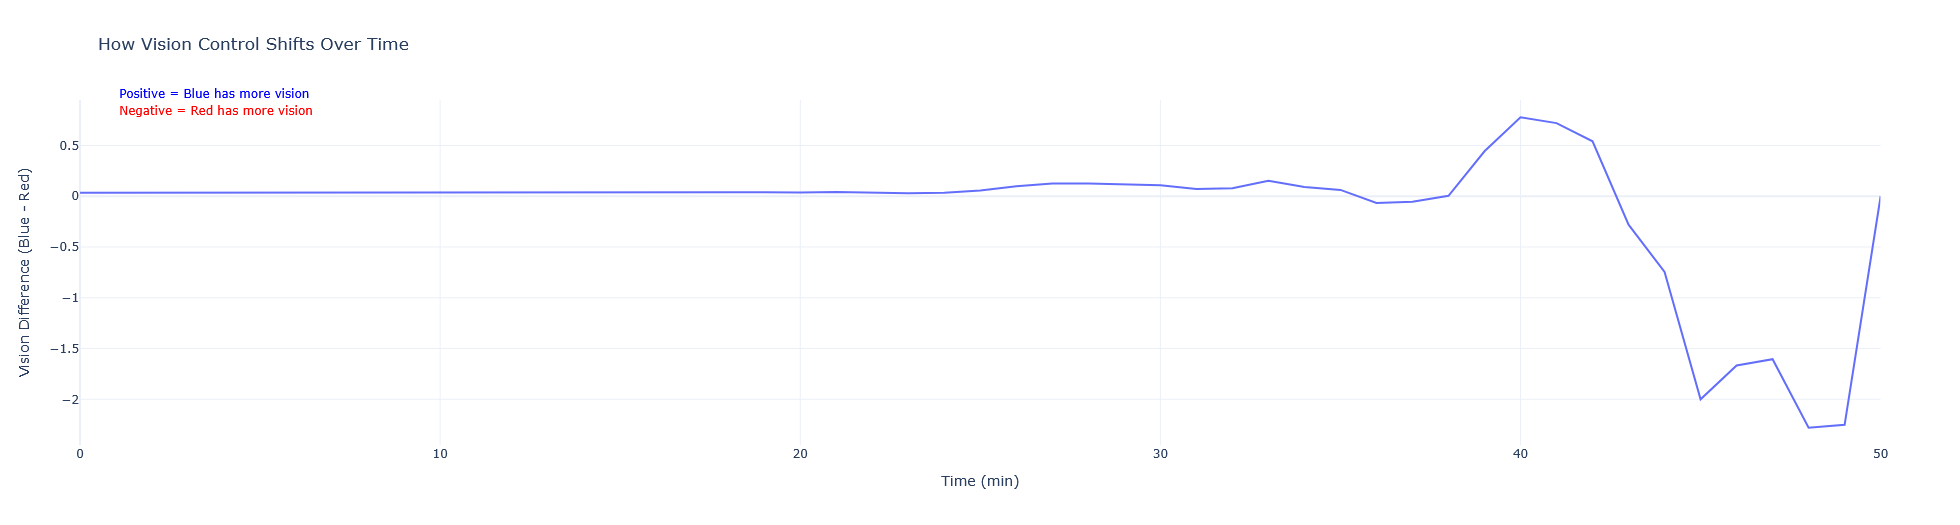

* The plot tracks how the balance of vision control shifts between the two teams as the match progresses.
* Blue briefly gains small advantages mid-game, but Red takes over heavily in the late stages before the values return toward neutral.

### **Events throughout the stages of the game**

In [ ]:
def phase(t):
    if t < 600: return "Early"
    elif t < 1500: return "Mid"
    return "Late"

df["phase"] = df["t"].apply(phase)

for event in ["baron", "dragon", "teamfight"]:
    phase_counts = df[df[event] == 1]["phase"].value_counts().reset_index()
    phase_counts.columns = ["Phase", "Count"]
    color_map = {"Early": "red", "Mid": "blue", "Late": "green"}
    fig = px.pie(phase_counts, names="Phase", values="Count", title=f"Game Phases When {event.capitalize()} Happens", hole=0.4)
    fig.show()

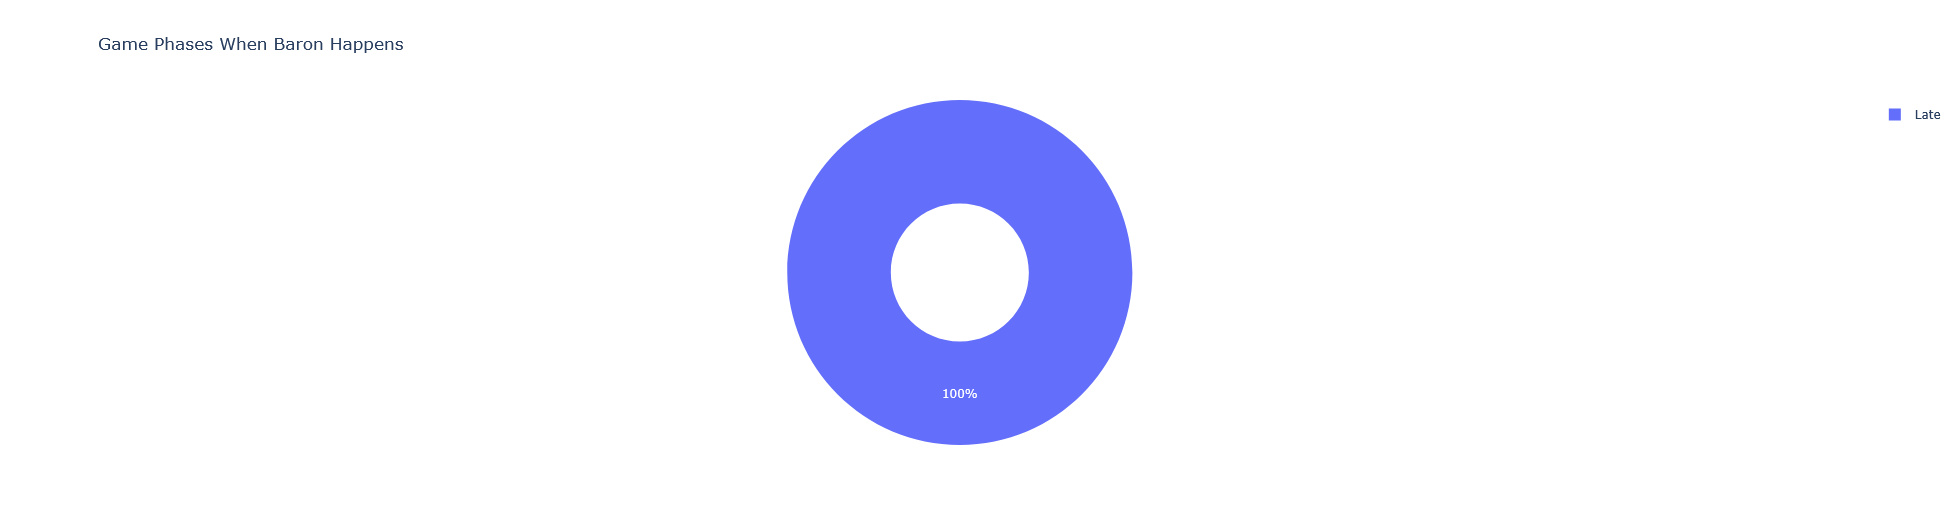

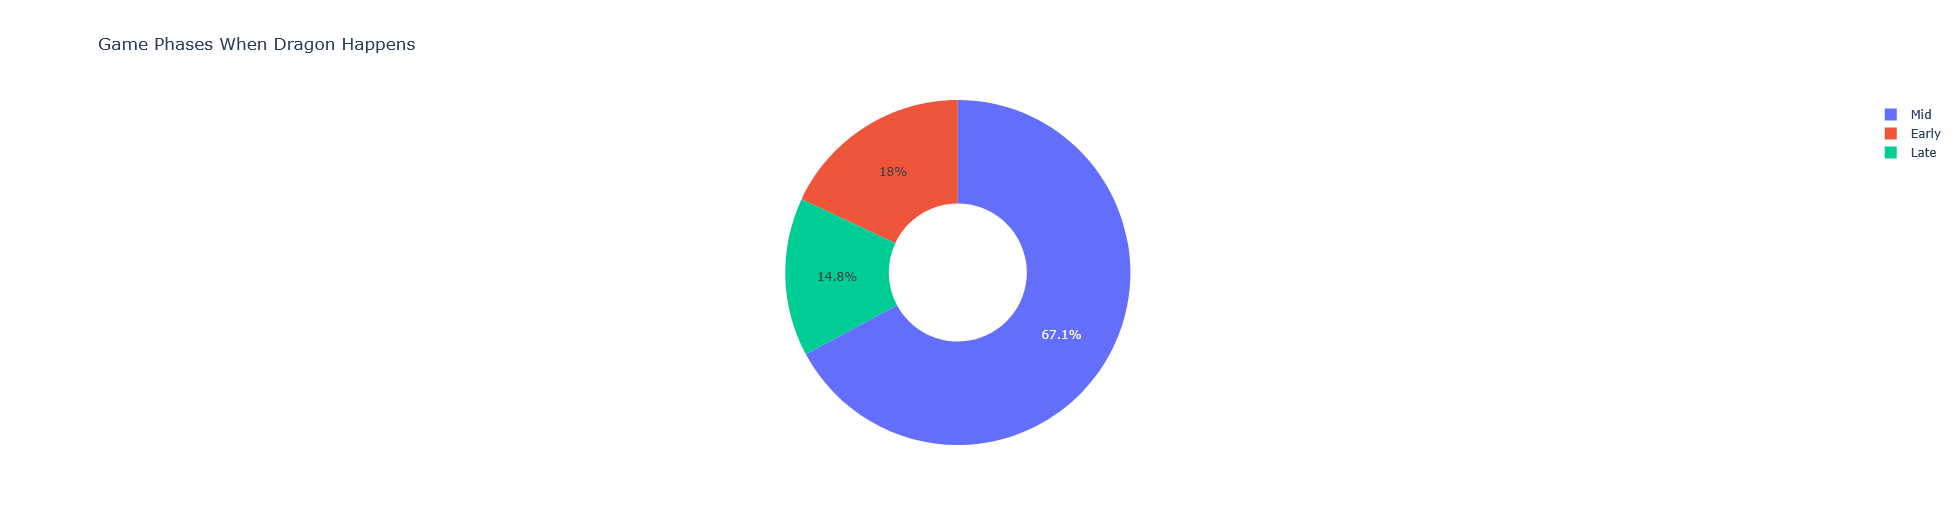

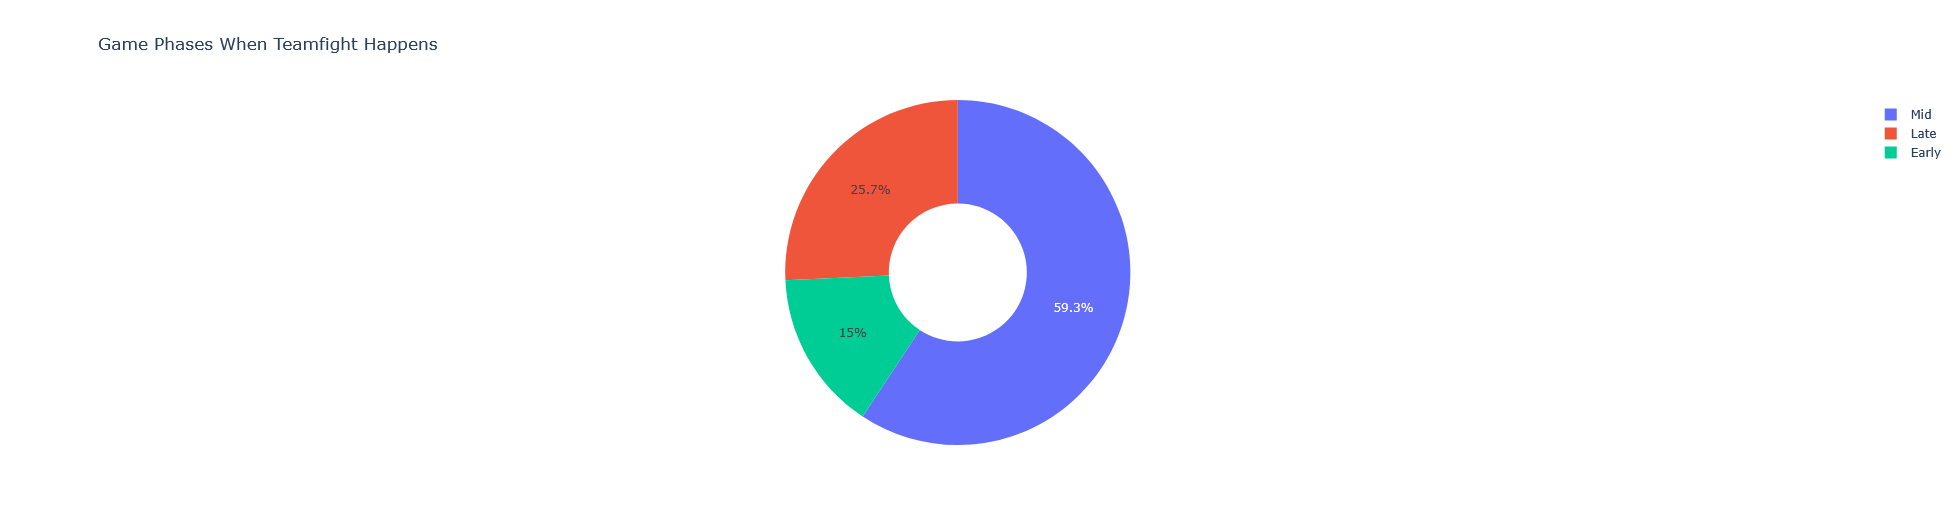

* Most teamfights and dragons occur during the mid-game, with 59 percent of teamfights and 67 percent of dragons appearing in this phase, while the early-game accounts for only about 15 percent of these events.
* Both events still have a noticeable share in the late-game, reflecting how objective pressure and scaling compositions increase encounter frequency as matches progress.
* Baron spawns exclusively in the late-game window, highlighting its role as a single decisive objective that only becomes available once teams are fully grouped and strategic play peaks.

### **Impact of Team Clustering on Major Event Probability**

In [ ]:
df["cluster_bin"] = pd.qcut(df["cluster_density"], q=5, labels=["Very Low", "Low", "Medium", "High", "Very High"])
df_cluster = (df.groupby("cluster_bin")[["baron", "dragon", "teamfight"]].mean().reset_index())

bin_map = {
    "Very Low":  "Spread Out",
    "Low":       "Loose Grouping",
    "Medium":    "Approaching",
    "High":      "Heavy Grouping",
    "Very High": "All-In Cluster"
}

df_cluster["cluster_bin"] = df_cluster["cluster_bin"].map(bin_map)
df_melt = df_cluster.melt(id_vars="cluster_bin", value_vars=["baron","dragon","teamfight"], var_name="event", value_name="probability")
color_map = {"baron": "blue", "dragon": "green", "teamfight": "red"}

fig = px.bar(df_melt, x="cluster_bin", y="probability", color="event", barmode="group", text=df_melt["probability"].round(3), color_discrete_map=color_map,
             title="Impact of Team Clustering on Major Event Probability",labels={"cluster_bin": "Team Clustering Level", "probability": "Probability (next 30s)", "event": "Event Type"})

fig.update_layout(template="plotly_white", height=500, width=950, title_font_size=20, legend_title_text="Event", xaxis_tickangle=-20,
                  xaxis=dict(title="Clustering Level (Spread to Fully Grouped)"), yaxis=dict(title="Event Probability"))
fig.update_traces(textposition="outside")
fig.show()

/tmp/ipython-input-2409022182.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



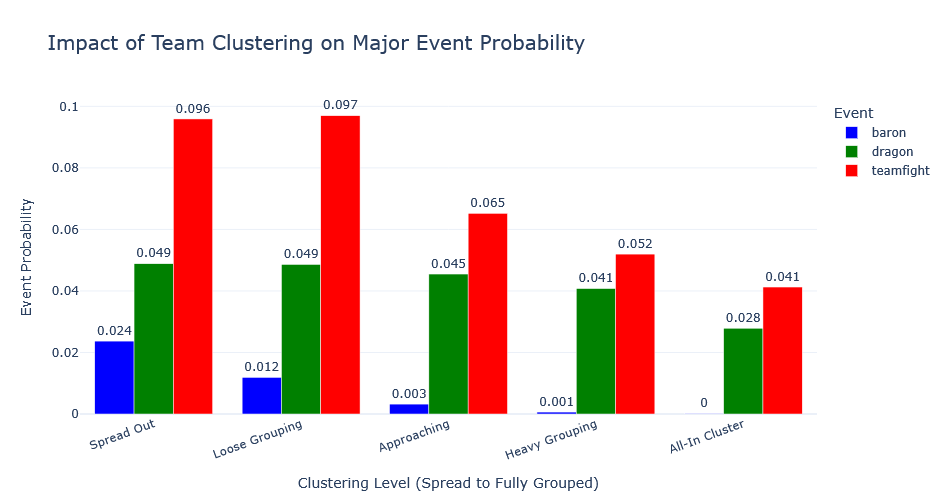

* Teams that stay spread out or loosely grouped have the highest likelihood of triggering major events, especially teamfights and dragons.
* As teams cluster more tightly, all event probabilities drop sharply, with Baron becoming almost nonexistent in fully grouped formations.

# **Final Summary**

* The exploratory work showed that the dataset captures the flow of a match with enough detail to reconstruct its internal rhythm. Economic trends such as gold and experience rose smoothly over time, but the differences between teams fluctuated in ways that lined up with meaningful shifts in momentum. This confirmed that advantage states in League of Legends behave as continuous signals rather than isolated spikes.
* Objective events revealed clear temporal identities. Dragon takes clustered in the mid-game where teams start contesting map control, while teamfights gradually increased as both sides formed larger groups. Baron attempts, by contrast, consistently appeared much later. This separation in timing demonstrated that each event type has its own developmental arc embedded in the match timeline.
* Spatial and positional features added another layer of structure. Variables such as cluster density, distance between teams and the number of champions near objectives consistently tightened in the seconds before major events. These patterns suggested that teams follow recognizable behavioral formations leading up to fights or objectives, making the lead-up more predictable than the event itself.
* Vision and map presence also showed systematic patterns. Differences in warding activity revealed which team was setting up for pressure, and this advantage often appeared before any actual confrontation. Instead of reacting to events, teams created information advantages that signaled their strategic intent well in advance.
* Bringing these observations together, the EDA made it clear that the problem is fundamentally temporal. The signals that precede objectives unfold across multiple steps and cannot be captured by single snapshots. This directly motivated a sequence-based modeling approach, where patterns across time, rather than isolated values, form the basis for predicting upcoming events in a match.